In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import mixed_precision

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

np.random.seed(42)
tf.random.set_seed(42)


In [2]:
print("TensorFlow version:", tf.__version__)
print("Available GPUs:", tf.config.list_physical_devices('GPU'))

# Enable mixed precision (VERY IMPORTANT for RTX GPUs)
mixed_precision.set_global_policy("mixed_float16")


TensorFlow version: 2.10.0
Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 2050, compute capability 8.6


In [3]:
BASE_DIR = "../data"
IMAGE_DIR = os.path.join(BASE_DIR, "images")
CSV_PATH = os.path.join(BASE_DIR, "HAM10000_metadata.csv")

IMG_SIZE = 224
BATCH_SIZE = 16
EPOCHS_STAGE_1 = 20
EPOCHS_STAGE_2 = 20
NUM_CLASSES = 7


In [4]:
df = pd.read_csv(CSV_PATH)

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

df['label'] = df['dx'].map(lesion_type_dict)
df['label_idx'] = pd.Categorical(df['label']).codes
df['path'] = df['image_id'].apply(lambda x: os.path.join(IMAGE_DIR, x + ".jpg"))

df['age'] = df['age'].fillna(df['age'].mean())

df.head()


,lesion_id,image_id,dx,dx_type,age,sex,localization,label,label_idx,path
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,../data\images\ISIC_0027419.jpg
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,../data\images\ISIC_0025030.jpg
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,../data\images\ISIC_0026769.jpg
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,../data\images\ISIC_0025661.jpg
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,Benign keratosis-like lesions,2,../data\images\ISIC_0031633.jpg


In [5]:
X_train, X_temp, y_train, y_temp = train_test_split(
    df['path'],
    df['label_idx'],
    test_size=0.2,
    stratify=df['label_idx'],
    random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.5,
    stratify=y_temp,
    random_state=42
)

print("Train:", len(X_train))
print("Val:", len(X_val))
print("Test:", len(X_test))


Train: 8012
Val: 1001
Test: 1002


In [6]:
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)

class_weights = dict(enumerate(class_weights))
class_weights


{0: 4.368593238822246,
 1: 2.7848453249913105,
 2: 1.3021290427433772,
 3: 12.440993788819876,
 4: 0.21338020666879728,
 5: 1.2860353130016051,
 6: 10.040100250626567}

In [7]:
AUTOTUNE = tf.data.AUTOTUNE

def load_image(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = tf.keras.applications.efficientnet_v2.preprocess_input(img)
    return img, label

train_ds = tf.data.Dataset.from_tensor_slices((X_train.values, y_train.values))
train_ds = train_ds.shuffle(1024).map(load_image, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((X_val.values, y_val.values))
val_ds = val_ds.map(load_image, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((X_test.values, y_test.values))
test_ds = test_ds.map(load_image, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)


In [8]:
from tensorflow.keras.applications import EfficientNetV2B2
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model

base_model = EfficientNetV2B2(
    include_top=False,
    weights="imagenet",
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)
outputs = Dense(NUM_CLASSES, activation="softmax", dtype="float32")(x)

model = Model(base_model.input, outputs)
model.summary()


35839040/35839040 [==============================] - 5s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  0           ['rescaling[0][0]']              
                                                                                                  
 stem_conv (Conv2D)          

In [9]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

model.compile(
    optimizer=Adam(1e-4),
    loss=SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)


In [10]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

callbacks = [
    EarlyStopping(patience=6, restore_best_weights=True),
    ReduceLROnPlateau(patience=3, factor=0.3, min_lr=1e-6),
    ModelCheckpoint("best_model.keras", save_best_only=True)
]


In [11]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_STAGE_1,
    class_weight=class_weights,
    callbacks=callbacks
)


Epoch 1/20
501/501 [==============================] - 172s 296ms/step - loss: 1.6830 - accuracy: 0.4009 - val_loss: 1.2584 - val_accuracy: 0.5764 - lr: 1.0000e-04
Epoch 2/20
501/501 [==============================] - 133s 266ms/step - loss: 1.3108 - accuracy: 0.5295 - val_loss: 1.1125 - val_accuracy: 0.6124 - lr: 1.0000e-04
Epoch 3/20
501/501 [==============================] - 116s 232ms/step - loss: 1.1938 - accuracy: 0.5721 - val_loss: 1.0957 - val_accuracy: 0.6134 - lr: 1.0000e-04
Epoch 4/20
501/501 [==============================] - 118s 236ms/step - loss: 1.1258 - accuracy: 0.5881 - val_loss: 1.0526 - val_accuracy: 0.6274 - lr: 1.0000e-04
Epoch 5/20
501/501 [==============================] - 116s 232ms/step - loss: 1.0646 - accuracy: 0.5955 - val_loss: 0.9877 - val_accuracy: 0.6374 - lr: 1.0000e-04
Epoch 6/20
501/501 [==============================] - 117s 234ms/step - loss: 0.9951 - accuracy: 0.6171 - val_loss: 0.9876 - val_accuracy: 0.6264 - lr: 1.0000e-04
Epoch 7/20
501/501 [==

In [12]:
base_model.trainable = True

for layer in base_model.layers[:-50]:
    layer.trainable = False

model.compile(
    optimizer=Adam(1e-5),
    loss=SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_STAGE_2,
    class_weight=class_weights,
    callbacks=callbacks
)


Epoch 1/20
501/501 [==============================] - 173s 283ms/step - loss: 1.0609 - accuracy: 0.4709 - val_loss: 1.1700 - val_accuracy: 0.5425 - lr: 1.0000e-05
Epoch 2/20
501/501 [==============================] - 126s 252ms/step - loss: 0.9303 - accuracy: 0.5577 - val_loss: 1.0332 - val_accuracy: 0.6054 - lr: 1.0000e-05
Epoch 3/20
501/501 [==============================] - 125s 250ms/step - loss: 0.8678 - accuracy: 0.5989 - val_loss: 0.9588 - val_accuracy: 0.6394 - lr: 1.0000e-05
Epoch 4/20
501/501 [==============================] - 124s 246ms/step - loss: 0.8440 - accuracy: 0.6234 - val_loss: 0.9065 - val_accuracy: 0.6653 - lr: 1.0000e-05
Epoch 5/20
501/501 [==============================] - 146s 292ms/step - loss: 0.8161 - accuracy: 0.6394 - val_loss: 0.9074 - val_accuracy: 0.6603 - lr: 1.0000e-05
Epoch 6/20
501/501 [==============================] - 194s 386ms/step - loss: 0.7770 - accuracy: 0.6565 - val_loss: 0.8620 - val_accuracy: 0.6693 - lr: 1.0000e-05
Epoch 7/20
501/501 [==

In [18]:


from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

# Unfreeze a few more deeper layers safely
for layer in base_model.layers[-80:]:
    layer.trainable = True

# Very small learning rate + label smoothing
model.compile(
    optimizer=Adam(learning_rate=5e-6),
    loss=SparseCategoricalCrossentropy(label_smoothing=0.1),
    metrics=["accuracy"]
)

history_boost = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    class_weight=class_weights,
    callbacks=callbacks
)


TypeError: SparseCategoricalCrossentropy.__init__() got an unexpected keyword argument 'label_smoothing'

In [13]:
test_loss, test_acc = model.evaluate(test_ds)
print("Test Accuracy:", test_acc)


63/63 [==============================] - 13s 203ms/step - loss: 0.7745 - accuracy: 0.7116
Test Accuracy: 0.7115768194198608


63/63 [==============================] - 16s 204ms/step
                               precision    recall  f1-score   support

             Melanocytic nevi       0.39      0.66      0.49        32
                     Melanoma       0.45      0.79      0.57        52
Benign keratosis-like lesions       0.60      0.62      0.61       110
         Basal cell carcinoma       0.24      0.73      0.36        11
            Actinic keratoses       0.95      0.75      0.84       671
             Vascular lesions       0.39      0.55      0.46       112
               Dermatofibroma       0.48      0.86      0.62        14

                     accuracy                           0.71      1002
                    macro avg       0.50      0.71      0.56      1002
                 weighted avg       0.79      0.71      0.74      1002



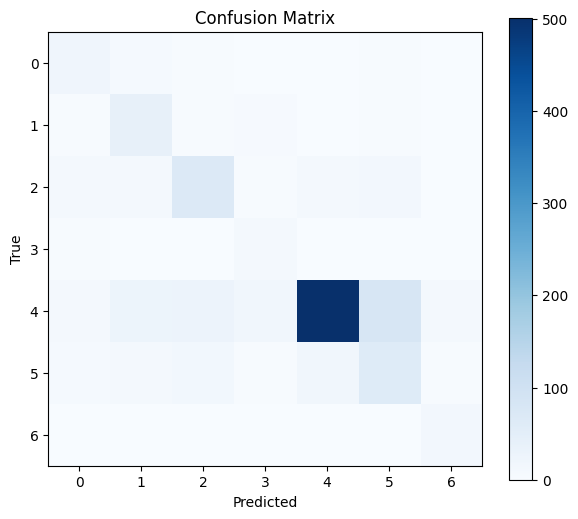

In [14]:
y_pred = np.argmax(model.predict(test_ds), axis=1)

print(classification_report(
    y_test,
    y_pred,
    target_names=lesion_type_dict.values()
))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(7,6))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.colorbar()
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [20]:
os.makedirs("../models", exist_ok=True)
model.save("../models/skin_efficientnet_v2_new.h5")
print("✅ Model saved successfully")


✅ Model saved successfully
